### Шаврина Татьяна
### Классификация отзывов к фильмам с помощью Vowpal Wabbit


In [60]:
from __future__ import division, print_function
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import re
import os
from subprocess import check_output
from sklearn.datasets import load_files
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.metrics import roc_auc_score, roc_curve

Populating the interactive namespace from numpy and matplotlib


In [36]:
reviews_train = load_files("/home/mi_air/aclImdb/aclImdb/train")
text_train, y_train = reviews_train.data, reviews_train.target

In [37]:
print("Number of documents in training data: %d" % len(text_train))
print(np.bincount(y_train))

Number of documents in training data: 25000
[12500 12500]


In [57]:
reviews_test = load_files("/home/mi_air/aclImdb//aclImdb/test")
text_test, y_test = reviews_test.data, reviews_test.target
print("Number of documents in test data: %d" % len(text_test))
print(np.bincount(y_test))

Number of documents in test data: 25000
[12500 12500]


In [58]:
y_test

array([1, 0, 1, ..., 0, 0, 0])

**Пример отзыва и соответствующей метки.**

In [40]:
text_train[1]

b'Words can\'t describe how bad this movie is. I can\'t explain it by writing only. You have too see it for yourself to get at grip of how horrible a movie really can be. Not that I recommend you to do that. There are so many clich\xc3\xa9s, mistakes (and all other negative things you can imagine) here that will just make you cry. To start with the technical first, there are a LOT of mistakes regarding the airplane. I won\'t list them here, but just mention the coloring of the plane. They didn\'t even manage to show an airliner in the colors of a fictional airline, but instead used a 747 painted in the original Boeing livery. Very bad. The plot is stupid and has been done many times before, only much, much better. There are so many ridiculous moments here that i lost count of it really early. Also, I was on the bad guys\' side all the time in the movie, because the good guys were so stupid. "Executive Decision" should without a doubt be you\'re choice over this one, even the "Turbulenc

In [41]:
y_train[1] # плохой отзыв

0

In [42]:
text_train[2]

b'Everyone plays their part pretty well in this "little nice movie". Belushi gets the chance to live part of his life differently, but ends up realizing that what he had was going to be just as good or maybe even better. The movie shows us that we ought to take advantage of the opportunities we have, not the ones we do not or cannot have. If U can get this movie on video for around $10, it\xc2\xb4d be an investment!'

In [43]:
y_train[2] # хороший отзыв

1

**Будем использовать функцию vowpalize, чтобы передать модели размеченные тексты.**

In [44]:
def vowpalize(document, label=None):
    return str(str(label) or '') + ' |text ' + ' '.join(re.findall('\w{3,}', str(document).lower())) + '\n'

In [45]:
vowpalize(text_train[1], 1 if y_train[0] == 1 else -1)

'1 |text words can describe how bad this movie can explain writing only you have too see for yourself get grip how horrible movie really can not that recommend you that there are many clich xc3 xa9s mistakes and all other negative things you can imagine here that will just make you cry start with the technical first there are lot mistakes regarding the airplane won list them here but just mention the coloring the plane they didn even manage show airliner the colors fictional airline but instead used 747 painted the original boeing livery very bad the plot stupid and has been done many times before only much much better there are many ridiculous moments here that lost count really early also was the bad guys side all the time the movie because the good guys were stupid executive decision should without doubt you choice over this one even the turbulence movies are better fact every other movie the world better than this one\n'

In [46]:
with open('/home/mi_air/aclImdb/aclImdb/output/movie_reviews_train.vw', 'w') as vw_train_data:
     for text_train, y_train in zip(reviews_train.data, reviews_train.target):
        vw_train_data.write(vowpalize(text_train, 1 if y_train == 1 else -1))
with open('/home/mi_air/aclImdb/aclImdb/output/movie_reviews_test.vw', 'w') as vw_test_data:
    for text_test, y_test in zip(reviews_test.data, reviews_test.target):
        vw_test_data.write(vowpalize(text_test, 1 if y_train == 1 else -1))

**Обучим модель Vowpal Wabbit. Передаем следующие агрументы:**

 - -d, путь к обучающей выборке (соотв. файл .vw )
 - --loss_function – Hinge (так как у нас SVM)
 - -f – путь к файлу, в который запишется модель (можно тоже в формате .vw)

In [47]:
!vw -d /home/mi_air/aclImdb/aclImdb/output/movie_reviews_train.vw --loss_function hinge -f /home/mi_air/aclImdb/aclImdb/output/movie_reviews_model.vw

final_regressor = /home/mi_air/aclImdb/aclImdb/output/movie_reviews_model.vw
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/mi_air/aclImdb/aclImdb/output/movie_reviews_train.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.000000 1.000000            1            1.0   1.0000   0.0000      105
1.324514 1.649029            2            2.0  -1.0000   0.6490      164
1.274999 1.225483            4            4.0  -1.0000   0.2310      110
1.071162 0.867325            8            8.0  -1.0000   0.4609      219
1.063382 1.055602           16           16.0   1.0000  -0.5401      204
0.987534 0.911686           32           32.0   1.0000   0.2172      190
1.016583 1.045631           64           64.0  -1.0000   0.3521      126
0.917219 0.817854          128          128.0  -1.0000  -1.0000      106
0.863816 0.8104

Сделаем прогноз для тестовой выборки с помощью обученной модели Vowpal Wabbit. Передаем следующие аргументы:
 - -i –путь к обученной модели (соотв. файл .vw)
 - -t -d – путь к тестовый выборке (соотв. файл .vw)
 - -p – путь к txt-файлу, куда запишутся прогнозы

In [48]:
!vw -i /home/mi_air/aclImdb/aclImdb/output/movie_reviews_model.vw -t -d /home/mi_air/aclImdb/aclImdb/output/movie_reviews_test.vw -p /home/mi_air/aclImdb/aclImdb/output/movie_reviews_test_predictions.txt

only testing
predictions = /home/mi_air/aclImdb/aclImdb/output/movie_reviews_test_predictions.txt
Num weight bits = 18
learning rate = 0.5
initial_t = 0
power_t = 0.5
using no cache
Reading datafile = /home/mi_air/aclImdb/aclImdb/output/movie_reviews_test.vw
num sources = 1
average  since         example        example  current  current  current
loss     last          counter         weight    label  predict features
1.678240 1.678240            1            1.0  -1.0000   0.2955       59
0.839120 0.000000            2            2.0  -1.0000  -1.0000      103
1.419560 2.000000            4            4.0  -1.0000  -1.0000      161
1.518091 1.616623            8            8.0  -1.0000  -1.0000      365
1.659781 1.801471           16           16.0  -1.0000   1.0000      319
1.839277 2.018772           32           32.0  -1.0000   0.9469       95
1.870033 1.900789           64           64.0  -1.0000  -0.8023      139
1.797922 1.725810          128          128.0  -1.0000  -0.7086     

**Посчитаем долю правильных ответов на тестовой выборке. Vowpal Wabbit прогнозирует числа в интервале [-1,1] – нужно перевести эти оценки превратить в бинарные прогнозы.**

In [49]:
from sklearn.metrics import accuracy_score


In [50]:
test_predicted_labels = [float(label) 
                         for label in open('/home/mi_air/aclImdb/aclImdb/output/movie_reviews_test_predictions.txt').readlines()]

In [51]:

test_predicted_labels_bin=[0 for i in range(len(test_predicted_labels))]

In [52]:
for i in range(len(test_predicted_labels)):
    if test_predicted_labels[i]>=0:
        test_predicted_labels_bin[i]=1
    else:
        test_predicted_labels_bin[i]=0

In [59]:
accuracy =  accuracy_score(y_test, test_predicted_labels_bin)
#print(y_test)
#print(test_predicted_labels_bin)
print(accuracy)

0.88204


Загрузим полученные предсказания, вычислим AUC и отобразим ROC-кривую:

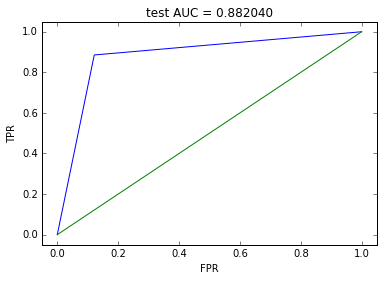

In [61]:

auc = roc_auc_score(y_test, test_predicted_labels_bin)
roc_curve = roc_curve(y_test, test_predicted_labels_bin)

plt.plot(roc_curve[0], roc_curve[1]);
plt.plot([0,1], [0,1])
plt.xlabel('FPR'); plt.ylabel('TPR'); plt.title('test AUC = %f' % (auc)); plt.axis([-0.05,1.05,-0.05,1.05]);